In [11]:
import tensorflow as tf
from tensorflow import keras
import resnet_V2
import matplotlib.pyplot as plt
from tqdm import tqdm
import data_util
import tensorflow.keras.backend as K

In [3]:
selected_layers = ['block1_conv1', 'block2_conv2',"block3_conv3" ,'block4_conv3','block5_conv4']
selected_layer_weights = [1.0, 4.0 , 4.0 , 8.0 , 16.0]

vgg = keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(256,256,3))
vgg.trainable = False
outputs = [vgg.get_layer(l).output for l in selected_layers]
model = keras.Model(vgg.input, outputs)

In [14]:
def perceptual_loss(input_image , reconstruct_image):
    h1_list = model(input_image)
    h2_list = model(reconstruct_image)

    rc_loss = 0.0
    for h1, h2, weight in zip(h1_list, h2_list, selected_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)

    return tf.reduce_mean(rc_loss)

In [ ]:
tf.random.set_seed(42)

In [7]:
input_size = 256
batch_size = 32

ae = resnet_V2.ResNetAE(drop_out=0.5)

In [8]:
train_ds, test_ds = data_util.get_autoencoder_dataset(batch_size=batch_size)

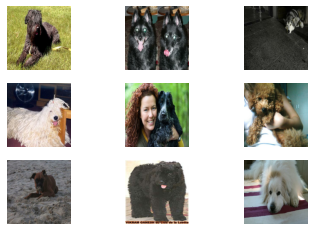

In [9]:
for images in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

In [16]:
mse = keras.losses.MeanSquaredError()

@tf.function
def train_step(x, model, optimizer):
    with tf.GradientTape() as tape:
        recon = model(x)
        loss = perceptual_loss(x, recon)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [17]:
def save_image(model, sample, epoch):
    sample = ae(sample)
    for i in range(4):
        ax = plt.subplot(2, 2, i +1)
        plt.imshow(sample[i].numpy())
        plt.axis('off')
        
    plt.savefig('./train_image/image_at_epoch_{:04d}.png'.format(epoch))
    plt.clf()
    plt.close()

In [18]:
sample = None
for t in test_ds.take(1):
    sample = t
sample.shape

TensorShape([32, 256, 256, 3])

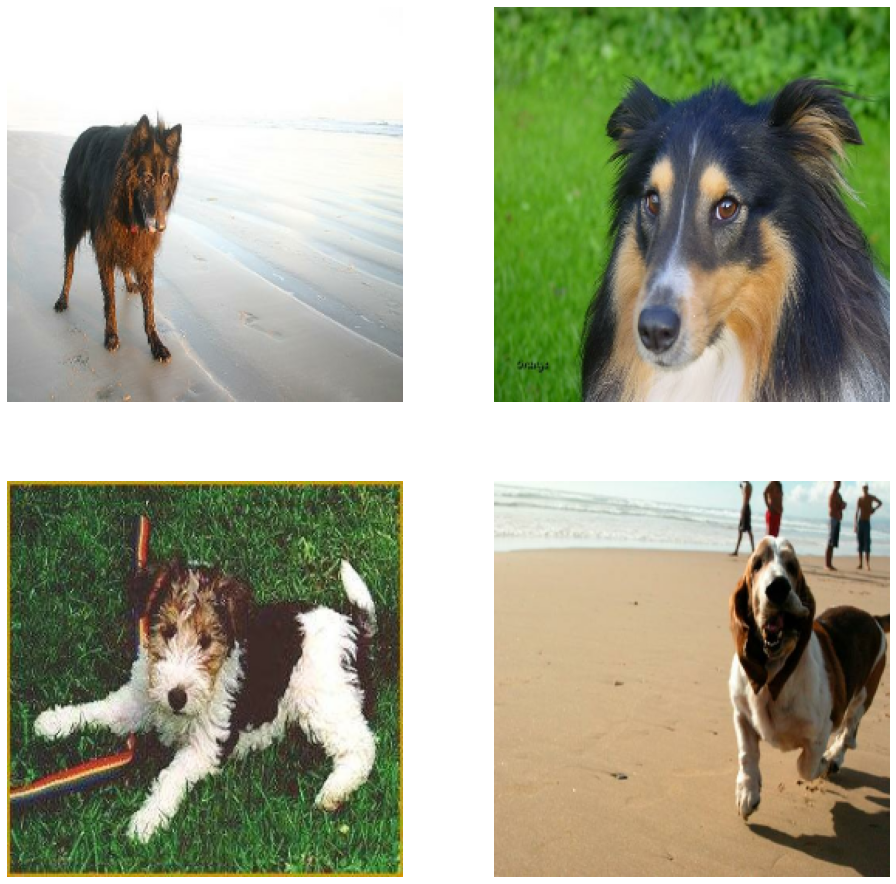

In [19]:
plt.figure(figsize=(16, 16))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(sample[i].numpy())
    plt.axis('off')

In [ ]:
optimizer = keras.optimizers.Adam()
epochs =100

ckpt_path = './ckpt/model_'
best_loss = 1
best_epoch = 0

for epoch in range(1, epochs + 1):
    for train_x in tqdm(train_ds, desc=str(epoch)):
        train_step(train_x, ae, optimizer)
        
    loss = tf.keras.metrics.Mean()
    
    for test_x in test_ds:
        test_recon = ae(test_x)
        loss(mse(test_x, test_recon))
        
    if loss.result() < best_loss:
        best_loss = loss.result()
        best_epoch = epoch
        
    print('epoch {} test loss {}'.format(epoch, loss.result()))
    print('best loss {} best epoch {}'.format(best_loss, best_epoch))
    print()
    
    ae.save_weights(ckpt_path + str(epoch) + '.ckpt')
    save_image(ae, sample, epoch)